# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

## 2. Set-up


### Emulation Mode


In [2]:
emulate = False

### Database Set-up


In [3]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [4]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [5]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748938041.4472513,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=10,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=260000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=260000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': SignalCalibrat

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [6]:
# create and connect to a session
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.20 16:43:55.219 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.20 16:43:55.220 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 16:43:55.221 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 16:43:55.269 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 16:43:56.675 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 16:43:56.816 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [7]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)

compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.20 16:43:57.851 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 16:43:57.947 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 16:43:58.169 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.20 16:43:58.169 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.20 16:43:58.169 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.20 16:43:58.803 laboneq.controller.controller  INFO   Starting near-time execution...
2023.09.20 16:43:59.237 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 16:44:09.672 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 16:44:20.102 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 16:44:30.336 laboneq.controller.controller  INFO   Finished near-time execution.


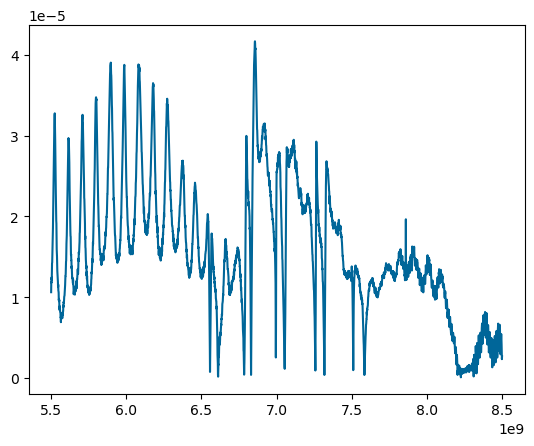

In [8]:
# access and plot results of one 8GHz sweep
full_data = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep, np.array(flatten([data for data in full_data])))

In [9]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

2023.09.20 16:44:37.734 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 16:44:37.736 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 16:44:37.743 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 16:44:39.082 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 16:44:39.267 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.20 16:44:39.463 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 16:44:39.473 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 16:44:39.487 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.20 16:44:39.488 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.20 16:44:39.488 laboneq.compiler.workflow.co

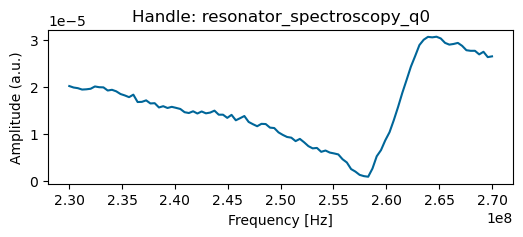

In [10]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 230e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
plot_results(cw_spectroscopy_results)

c:\Users\ZI_at_PSI\anaconda3\envs\labone_q_training\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


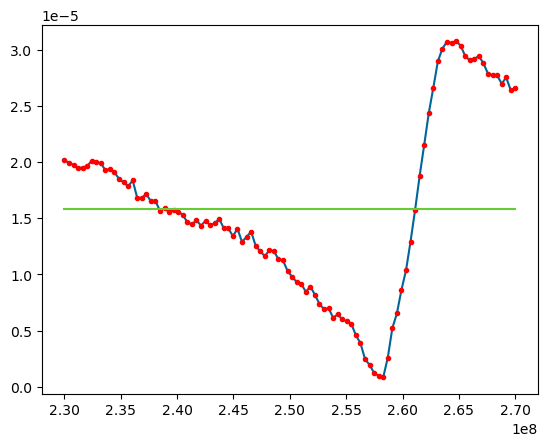

1480089705.263907

In [11]:
analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [12]:
first_readout_res = 7.0e9 + 2.60e8

In [13]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Spectroscopy vs Power - "Punchout" NOT TESTED


In [ ]:
freq_upper = (
    transmon_list[0].parameters.readout_resonator_frequency
    - transmon_list[0].parameters.readout_lo_frequency
    + 50e6
)
freq_lower = (
    transmon_list[0].parameters.readout_resonator_frequency
    - transmon_list[0].parameters.readout_lo_frequency
    - 50e6
)

amp_sweep = SweepParameter(
    uid="amp_sweep2",
    values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=21),
)

punchout = res_spectroscopy_pulsed_amp_sweep(
    qubit=transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_gauss_square_pulse,
    frequency_sweep=create_freq_sweep(
        f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
    ),
    amplitude_sweep=amp_sweep,
    num_averages=2**10,
    measure_range=-25,
    acquire_range=-5,
)

comp_punchout = session.compile(punchout)
punchout_result = session.run(comp_punchout)

In [ ]:
plot_results(punchout_result)

In [ ]:
save_results(
    demo_results_db,
    punchout_result,
    "punchout",
    "neg_25_meas_neg_5_acq_range",
)

In [ ]:
qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [14]:
def gen_const_pulse(qubit, length=5e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [15]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-25
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [16]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=10e6,
    qspec_num=501,
    num_averages=2**8,
)


2023.09.20 16:45:01.744 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 16:45:01.745 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 16:45:01.749 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 16:45:03.080 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 16:45:03.226 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.20 16:45:03.463 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 16:45:03.624 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 16:45:04.925 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 43
2023.09.20 16:45:04.926 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8064
2023.09.20 16:45:04.926 laboneq.compiler.workflow

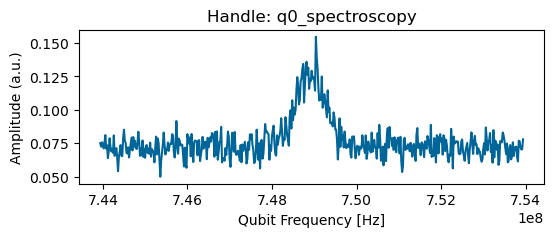

In [17]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)
plot_results(qspec_res)

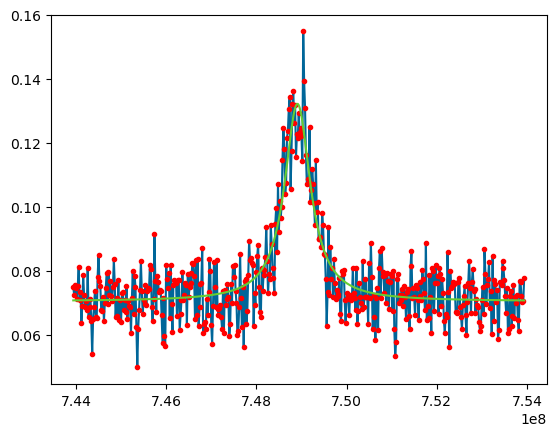

748909294.399337


In [20]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.45e8,a=0.03,gamma=1E6, flip=False)
print(qubit_resonance)

### Update qubit resonance

In [21]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748909294.399337


## Amplitude Rabi

In [22]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [26]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = 0.9
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = 0.9/2
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [27]:
transmon_list[0].parameters.user_defined["amplitude_pi"]

0.9

2023.09.20 16:50:43.004 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 16:50:43.011 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 16:50:43.047 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 294
2023.09.20 16:50:43.047 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8832
2023.09.20 16:50:43.048 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.20 16:50:43.048 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 16:50:43.049 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 16:50:43.055 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 16:50:44.490 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 16:50:44.631 laboneq.controller.devices.device

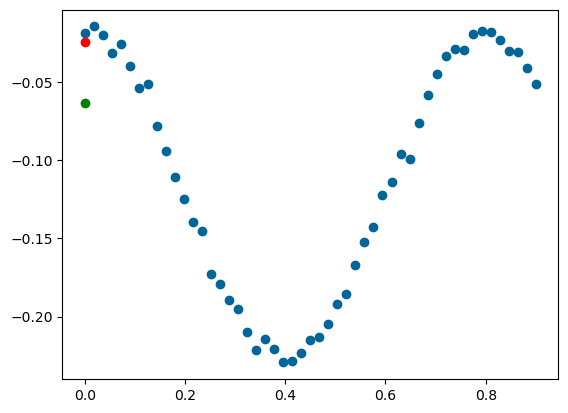

In [28]:
amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=0.9, count=51)


amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_gaussian_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=amplitude_sweep,
    num_averages=2**10,
    pi_amplitude=transmon_list[0].parameters.user_defined["amplitude_pi"],
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)

#plot_with_trace_rabi(rabi_res)

handles = list(rabi_res.acquired_results.keys())
res1 = np.asarray(rabi_res.get_data(handles[0]))
res2= np.asarray(rabi_res.get_data(handles[1]))

#plt.plot(np.real(res1), np.imag(res1), 'o')
#plt.plot(np.real(res2[0]), np.imag(res2[0]), 'ro') # ground
#plt.plot(np.real(res2[1]), np.imag(res2[1]), 'go') # excited

plt.plot(amplitude_sweep.values, np.imag(res1), 'o')
plt.plot(np.imag(res2[0]), 'ro') # ground
plt.plot(np.imag(res2[1]), 'go') # excited


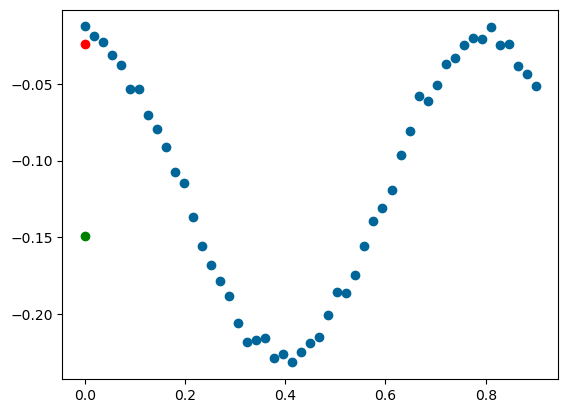

In [217]:
handles = list(rabi_res.acquired_results.keys())
res1 = np.asarray(rabi_res.get_data(handles[0]))
res2= np.asarray(rabi_res.get_data(handles[1]))

#plt.plot(np.real(res1), np.imag(res1), 'o')
#plt.plot(np.real(res2[0]), np.imag(res2[0]), 'ro') # ground
#plt.plot(np.real(res2[1]), np.imag(res2[1]), 'go') # excited

plt.plot(amplitude_sweep.values, np.imag(res1), 'o')
plt.plot(np.imag(res2[0]), 'ro') # ground
plt.plot(np.imag(res2[1]), 'go') # excited

In [171]:
amplitude_rabi_single??

Signature:
amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=1024,
    cal_trace=False,
    pi_amplitude=0.5,
)
Docstring: <no docstring>
Source:   
def amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_rabi = Experiment(
        uid="Qubit Spectroscopy",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
            ]
        ),


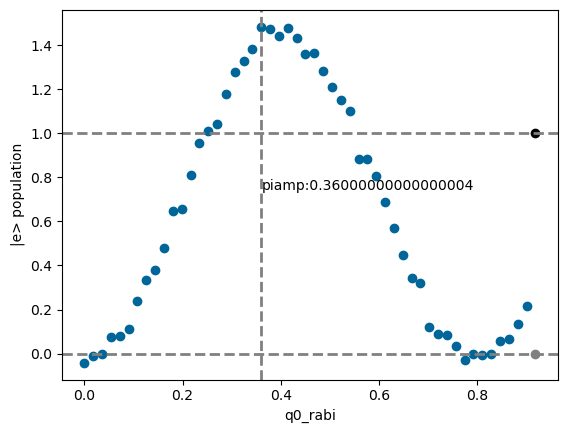

In [168]:
plot_with_trace_rabi(rabi_res)

In [206]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = 0.9
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = 0.9/2
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## Ramsey

In [200]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
                if cal_trace:
                    with exp_ramsey.section(uid="cal_trace_gnd"):
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )
                    with exp_ramsey.section(uid="cal_trace_exc"):
                        exp_ramsey.play(
                            signal=f"drive_{qubit.uid}",
                            pulse=drive_pulse(qubit),
                            amplitude=pi_amplitude,
                        )
                        
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )

    return exp_ramsey

In [192]:
transmon_list[0].parameters.user_defined["amplitude_pi2"]

0.2

In [193]:
#print(demo_setup.get_calibration())

In [194]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

In [199]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=2000e-9, count=20)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, 
                             cal_trace=True)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.09.20 14:29:07.362 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.20 14:29:07.363 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.20 14:29:07.367 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.20 14:29:08.770 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.20 14:29:08.915 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.20 14:29:09.170 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 14:29:09.177 laboneq.compiler.scheduler.scheduler WARNING Topological order of the acquires for handle q0_ramsey_cal_trace does not match time order.
2023.09.20 14:29:09.179 laboneq.compiler.scheduler.scheduler WARNING Topological order of the acquires for handle q0_ramsey_cal_trace does not match time order.
2023.09.20 14

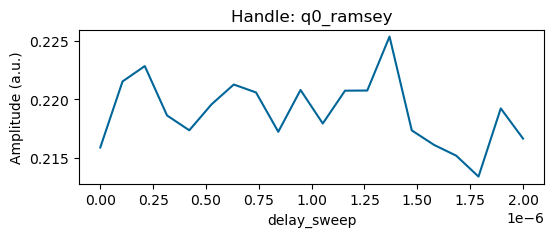

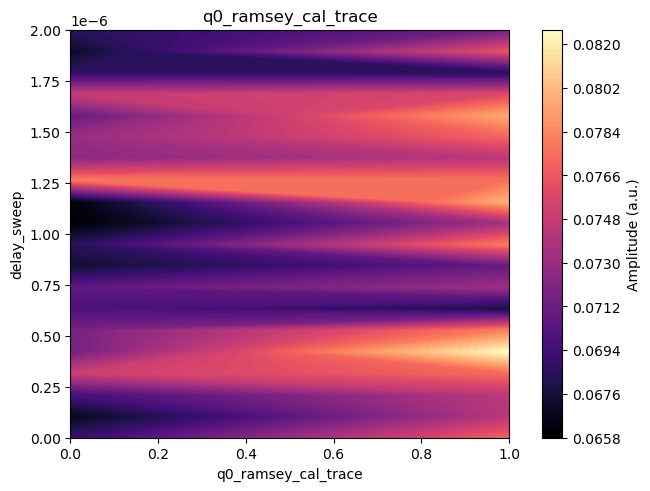

In [201]:
plot_results(res_ramsey)

In [202]:
def plot_with_trace_ramsey(res):
    handles = list(res.acquired_results.keys())
    res1 = np.asarray(res.get_data(handles[0]))
    res_cal_trace= np.asarray(res.get_data(handles[1]))
    axis1 = res.get_axis(handles[0])[0]
    delta_x = axis1[-1]-axis1[-2]
    axis2 = np.linspace(axis1[-1]+delta_x,axis1[-1] + 2*delta_x,2)

    delta_vec = res_cal_trace[1] -res_cal_trace[0]
    angle = np.angle(delta_vec)
    rd = []
    for r in [res1,res_cal_trace]:
        r = r - res_cal_trace[0]
        r = r * np.exp(-1j*angle)
        r = r/ np.abs(delta_vec)
        rd.append(r)
        
    pi_amp = axis1[np.argmax(np.real(rd[0]))]

    plt.xlabel(handles[0])
    plt.ylabel("|e> population")
    plt.plot(axis1,np.real(rd[0]),'o')
    plt.plot(axis2[0],np.real(rd[1][0]),'o', color="gray")
    plt.plot(axis2[0],np.real(rd[1][1]),'o', color="black")
    plt.axhline(y=np.real(rd[1][0]), color='gray', linestyle='--', linewidth=2)
    plt.axhline(y=np.real(rd[1][1]), color='gray', linestyle='--', linewidth=2)
    # plt.axvline(x=pi_amp, color='gray', linestyle='--', linewidth=2)
    # plt.text(x=pi_amp,y = max(np.real(rd[0]))/2, s= f"piamp:{pi_amp}")
    plt.plot()

In [203]:
plot_with_trace_ramsey(res_ramsey)

ValueError: operands could not be broadcast together with shapes (20,) (2,) 